# Notebook Overview

This notebook is a coding assessment for a lab that I am applying to. The task is to implement a training method called **GEORGE** which is described in this [paper](https://arxiv.org/abs/2011.12945). We will utilize the SpuCo library which can be found [here](https://spuco.readthedocs.io/en/latest/index.html).

The **GEORGE** framework consists mainly of two steps:
1. Estimate the subclasses of a *superclass* using clustering techniques (UMAP, K-means)
2. Train a model using the subclasses we found (GDRO loss)

This allows us to create a model that has elevated performance on the worst performing class/subclass. In the paper, they mention that this could be particularly important in the medical field.

## Importing Data

Our first task is to import the data. We will be using the SpuCoMNIST dataset which augments spurious correlations on the dataset by changing sections of the background to be a certain color for a specific class.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from spuco.datasets import SpuCoMNIST, SpuriousFeatureDifficulty

classes = [[i] for i in range(10)]  
difficulty = SpuriousFeatureDifficulty.MAGNITUDE_LARGE

train_data = SpuCoMNIST(root="./data_train/",
    spurious_feature_difficulty=difficulty,
    classes=classes,
    spurious_correlation_strength=0.9,
    split="train",
    download=True,)

train_data.initialize()

test_data = SpuCoMNIST(root="./data_test/",
    spurious_feature_difficulty=difficulty,
    classes=classes,
    split="test",
    download=True,)

test_data.initialize()

print(f"Train data size: {len(train_data)}, Test data size: {len(test_data)}")

Train data size: 48004, Test data size: 10000


Here is a visual of some of our data samples:

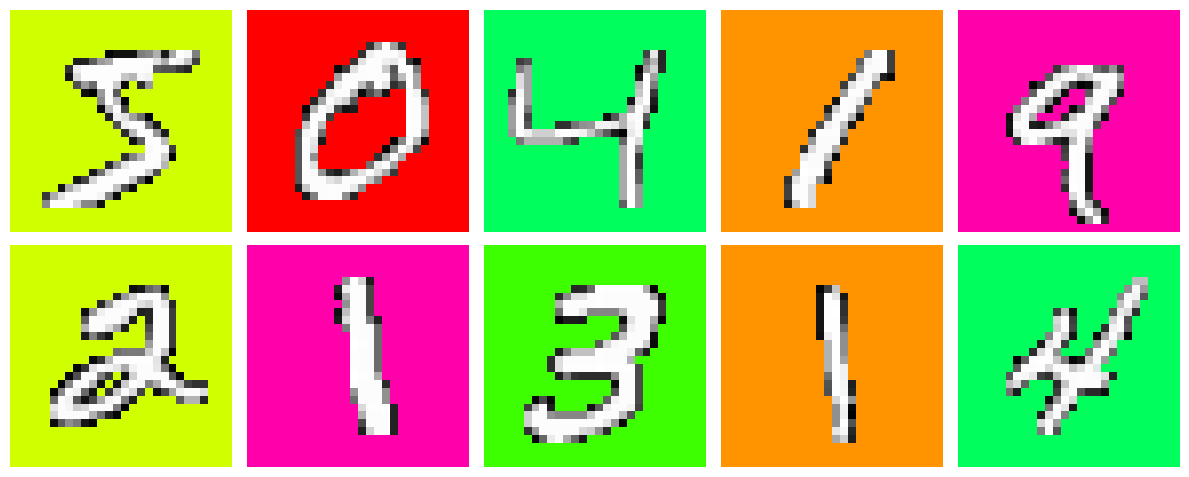

In [2]:
import torchvision.transforms as T

fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flatten()):
    image, _ = train_data[i]
    ax.imshow(T.ToPILImage()(image))
    ax.axis("off")
plt.tight_layout()
plt.show()

## Training ERM Model

In this section we will train a basic model that utilizes an Empirical Risk Minimization (ERM) principle i.e., we maximize the average performance. Since we are working with an image dataset, we select the LeNet architecture as it is the most suitable for our purposes.

In [3]:
import torch
from torch import optim
from spuco.models import model_factory 
from spuco.utils import Trainer

num_classes = len(classes)
input_shape = train_data[0][0].shape
device = "cuda" if torch.cuda.is_available() else "cpu"

leNet_model = model_factory("lenet", input_shape, num_classes, pretrained=False)
optimizer = optim.Adam(leNet_model.parameters(), lr=0.001)

erm = Trainer(train_data,leNet_model, batch_size=128, optimizer=optimizer, device=device, verbose=0) # default loss is CrossEntropyLoss
erm.train(5)

/Users/artemkiryukhin/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


And here we will use the `Evaluator` class provided by the SpuCo library to see how our base model performs.

In [4]:
from spuco.evaluate import Evaluator

true_gp = test_data.group_partition
true_wt = train_data.group_weights  

ev_erm = Evaluator(testset=test_data, group_partition=true_gp, group_weights=true_wt,
                   batch_size=32, model=leNet_model, device=device, verbose=0)
ev_erm.evaluate()
print(f"ERM = {ev_erm.average_accuracy} | Worst = {ev_erm.worst_group_accuracy}")

Evaluating group-wise accuracy: 100%|██████████| 100/100 [19:42<00:00, 11.83s/it]

ERM = 96.36147994655153 | Worst = ((9, 4), 25.742574257425744)


## Clustering Subclasses

Now we can move on to finding the subclasses of each superclass in the model. We utilize the base model's representations as the vectors for our clustering. In the paper, UMAP was used first, so we will replicate that process as well. There are parameters to tune for UMAP, but this is a topic outside the scope of this notebook. 

After we perform the UMAP transformation, we iterate through every class and perform K-means clustering within that class. To select *k*, we once again mimic the paper's suggestions and use a silhouette score to automatically find the best *k* value. After that is done, we store the subclasses and the indices of the examples that get clustered to the subclass in a dictionary: `{(class_label, subclass_id) : List of subclass element id's}` 

In [5]:
from umap.umap_ import UMAP
from spuco.group_inference import Cluster, ClusterAlg

Z = erm.get_trainset_outputs(features=True)
Z_umap = UMAP(n_neighbors=10, min_dist=0.1, n_components=10).fit_transform(Z)
print(f"UMAP embedding shape: {Z_umap.shape}")
labels = [train_data[i][1] for i in range(len(train_data))]  

group_partition = {}
for label in set(labels):
    label_indices = [i for i, y in enumerate(labels) if y == label]
    Z_label = Z_umap[label_indices]

    clusterer = Cluster(
        Z=Z_label,
        cluster_alg=ClusterAlg.KMEANS,
        max_clusters=12,       
        device=device,
        verbose=0
    )
    partition, sil_score = clusterer.silhouette(Z_label)  

    for subclass_id, local_indices in partition.items():
        global_indices = [label_indices[j] for j in local_indices]
        group_partition[(label, subclass_id)] = global_indices

UMAP embedding shape: (48004, 10)


/Users/artemkiryukhin/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


We can print how many subclasses we now have.

In [6]:
print(f"Identified {len(group_partition)} groups.")
print(group_partition.keys())

Identified 42 groups.
dict_keys([(0, 0), (0, 2), (0, 1), (1, 1), (1, 2), (1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 2), (3, 3), (3, 1), (3, 4), (4, 0), (4, 3), (4, 1), (4, 2), (5, 2), (5, 0), (5, 3), (5, 4), (5, 1), (5, 5), (6, 0), (6, 4), (6, 3), (6, 2), (6, 1), (7, 0), (7, 2), (7, 3), (7, 1), (8, 0), (8, 1), (8, 2), (9, 1), (9, 2), (9, 4), (9, 3), (9, 0)])


## Training with Group Balancing

We will now retrain the model using group balancing sampling. While this is still an ERM based method, the use of our subclasses and the fact that all the training samples appear at the same frequency makes it so the model is encouraged to not sacrifice performance on any subset of our dataset. The implementation is easy with the SpuCo library.

In [7]:
from spuco.robust_train import GroupBalanceBatchERM

leNet_model_subclasses = model_factory("lenet", input_shape, num_classes, pretrained=False)
optimizer = optim.Adam(leNet_model_subclasses.parameters(), lr=0.001)

groupBalanced = GroupBalanceBatchERM(
    model=leNet_model_subclasses,
    trainset=train_data,
    group_partition=group_partition,  
    batch_size=128,                    
    optimizer=optimizer,
    num_epochs=5,
    device=device,
    verbose=0,
)
groupBalanced.train()

And to evaluate our new model.

In [8]:
ev_gb = Evaluator(
    testset=test_data,
    group_partition=test_data.group_partition,
    group_weights=train_data.group_weights,
    batch_size=128,
    model=leNet_model_subclasses,
    device=device,
    verbose=0,
)
ev_gb.evaluate()
print(f"Avg = {ev_gb.average_accuracy} | Worst = {ev_gb.worst_group_accuracy}")

Evaluating group-wise accuracy: 100%|██████████| 100/100 [19:37<00:00, 11.77s/it]

Avg = 97.41042940721277 | Worst = ((7, 1), 87.37864077669903)


## GDRO Model

Although not a part of the application assignment, I wanted to replicate the use of GDRO as done in the paper. The GDRO loss aims to minimize the loss of the worst group by changing the weights of how much each group's loss contributes to the cost function. 

In [9]:
from spuco.datasets import GroupLabeledDatasetWrapper
from spuco.robust_train import GroupDRO

subclasses_trainset = GroupLabeledDatasetWrapper(train_data, group_partition)
leNet_model_GRO = model_factory("lenet", input_shape, num_classes, pretrained=False)
optimizer = optim.Adam(leNet_model_GRO.parameters(), lr=0.001)

gdro = GroupDRO(
    model=leNet_model_GRO,
    trainset=subclasses_trainset,
    batch_size=128,     
    optimizer=optimizer,
    num_epochs=5,
    device=device,
    verbose=0,
)
gdro.train()

In [10]:
ev_gdro = Evaluator(
    testset=test_data,
    group_partition=test_data.group_partition,
    group_weights=train_data.group_weights,
    batch_size=128,
    model=leNet_model_GRO,
    device=device,
    verbose=0,
)
ev_gdro.evaluate()
print(f"Avg = {ev_gdro.average_accuracy} | Worst = {ev_gdro.worst_group_accuracy}")

Evaluating group-wise accuracy: 100%|██████████| 100/100 [22:25<00:00, 13.46s/it]

Avg = 96.75315085181579 | Worst = ((2, 9), 88.3495145631068)


## Visuals and Conclusions

As we can see our implementation of the **GEORGE** framework has worked. The worst group accuracy for the Group-Balanced and the GDRO has increased by about 61% and 62% compared to the base ERM training. In addition, we even saw a tiny increase in the average accuracy in both of the subclass training methods.

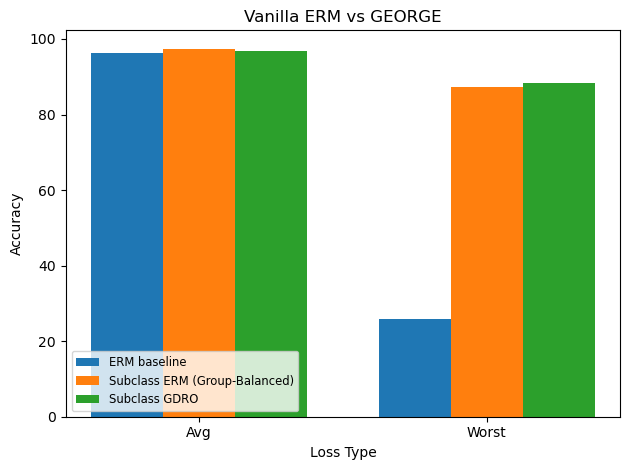

In [17]:
names = ["Avg", "Worst"]

erm_vals   = [ev_erm.average_accuracy, ev_erm.worst_group_accuracy[1]]
gb_vals    = [ev_gb.average_accuracy,  ev_gb.worst_group_accuracy[1]]
gdro_vals  = [ev_gdro.average_accuracy, ev_gdro.worst_group_accuracy[1]]

x = np.arange(2)
w = 0.25

plt.bar(x - w, erm_vals, width=w, label="ERM baseline")
plt.bar(x, gb_vals, width=w, label="Subclass ERM (Group-Balanced)")
plt.bar(x + w, gdro_vals, width=w, label="Subclass GDRO")

plt.xticks(x, names)
plt.ylabel("Accuracy")
plt.xlabel("Loss Type")
plt.title("Vanilla ERM vs GEORGE")
plt.legend(loc="lower left", fontsize="small")
plt.tight_layout()
plt.show()